In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sicapv2/SICAPv2/SICAPv2/readme.txt
/kaggle/input/sicapv2/SICAPv2/SICAPv2/wsi_labels.xlsx
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/16B0006669_Block_Region_24_6_2_xini_14275_yini_13598.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/18B0005230E_Block_Region_5_11_23_xini_38257_yini_96363.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/18B0006621D_Block_Region_2_1_13_xini_21582_yini_66086.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/18B0006177A_Block_Region_2_6_19_xini_51693_yini_147491.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/16B0022612_Block_Region_1_20_12_xini_15667_yini_92428.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/17B0035220_Block_Region_5_22_18_xini_39584_yini_76503.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/16B0022615_Block_Region_4_19_41_xini_44968_yini_22920.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/17B0034247_Block_Region_2_21_7_xini_39052_yini_24363.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/18B0005478I_Block_Region_2_1

In [2]:
import os
from pathlib import Path
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# Base paths
BASE_DIR = Path("/kaggle/input/sicapv2/SICAPv2/SICAPv2")
IMG_DIR = BASE_DIR / "images"
VAL_DIR = BASE_DIR / "partition" / "Validation"
TEST_DIR = BASE_DIR / "partition" / "Test"

# Labels
labels_df = pd.read_excel(BASE_DIR / "wsi_labels.xlsx")
labels_df.columns = [c.lower().strip() for c in labels_df.columns]  # clean col names


Using: cuda


In [4]:
# Get filenames from partitions
val_files = set(os.listdir(VAL_DIR))
test_files = set(os.listdir(TEST_DIR))
all_files = set(os.listdir(IMG_DIR))
train_files = all_files - val_files - test_files

def make_split_df(file_set, split):
    df = labels_df[labels_df['slide_id'].isin(file_set)].copy()  # change 'image_id' if col name differs
    df['split'] = split
    return df

df_train = make_split_df(train_files, 'train')
df_val = make_split_df(val_files, 'val')
df_test = make_split_df(test_files, 'test')

df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)
print(df_all['split'].value_counts())
df_all.head()


Series([], Name: count, dtype: int64)


Empty DataFrame
Columns: [slide_id, patient_id, gleason_primary, gleason_secondary, split]
Index: []

In [5]:
import os
from pathlib import Path
import pandas as pd

# Paths
BASE_DIR = Path("/kaggle/input/sicapv2/SICAPv2/SICAPv2")
IMG_DIR = BASE_DIR / "images"
VAL_DIR = BASE_DIR / "partition" / "Validation"
TEST_DIR = BASE_DIR / "partition" / "Test"

# Load labels
labels_df = pd.read_excel(BASE_DIR / "wsi_labels.xlsx")
labels_df.columns = [c.lower().strip() for c in labels_df.columns]

# Map slide_id → row
slide_to_row = {str(row.slide_id): row for row in labels_df.itertuples(index=False)}

# Helper: find split
def get_split(filename):
    if filename in os.listdir(VAL_DIR):
        return "val"
    elif filename in os.listdir(TEST_DIR):
        return "test"
    else:
        return "train"

# Build dataset rows
dataset_rows = []
for fname in os.listdir(IMG_DIR):
    slide_prefix = fname.split("_")[0]  # take part before first underscore
    if slide_prefix in slide_to_row:
        row = slide_to_row[slide_prefix]
        dataset_rows.append({
            "image_path": str(IMG_DIR / fname),
            "slide_id": slide_prefix,
            "patient_id": row.patient_id,
            "gleason_primary": row.gleason_primary,
            "gleason_secondary": row.gleason_secondary,
            "split": get_split(fname)
        })

df_all = pd.DataFrame(dataset_rows)
print(df_all["split"].value_counts())
df_all.head()


split
train    18783
Name: count, dtype: int64


image_path     slide_id  patient_id  \
0  /kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...   16B0006669       14107   
1  /kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...  18B0005230E      779857   
2  /kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...  18B0006621D      360511   
3  /kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...  18B0006177A      742963   
4  /kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...   16B0022612      296752   

   gleason_primary  gleason_secondary  split  
0                5                  5  train  
1                3                  4  train  
2                4                  3  train  
3                4                  5  train  
4                3                  4  train

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

# Base directory where the dataset is mounted
base_dir = "/kaggle/input/sicapv2"

# Check directory structure
for root, dirs, files in os.walk(base_dir):
    print(f"{root} -> {len(files)} files")


/kaggle/input/sicapv2 -> 0 files
/kaggle/input/sicapv2/SICAPv2 -> 0 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2 -> 2 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images -> 18783 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/partition -> 0 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/partition/Validation -> 0 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/partition/Validation/Val3 -> 4 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/partition/Validation/Val4 -> 4 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/partition/Validation/Val2 -> 4 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/partition/Validation/Val1 -> 4 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/partition/Test -> 4 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/masks -> 18783 files


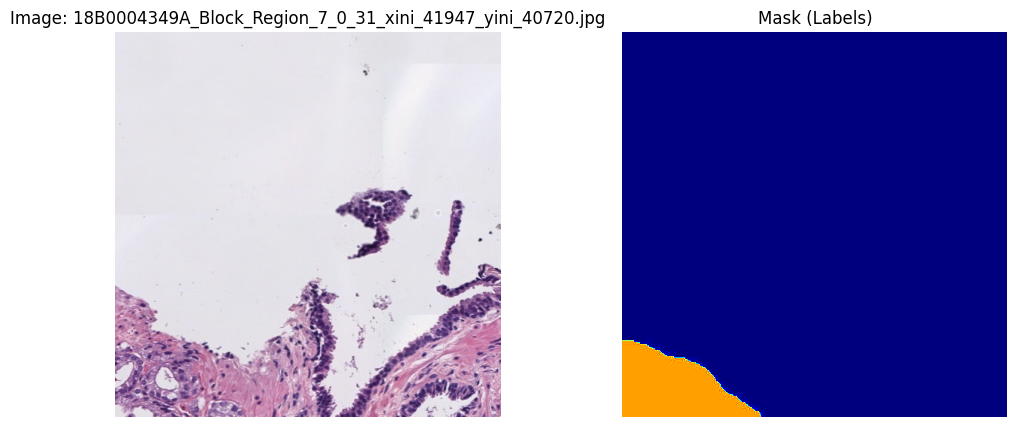

In [7]:
import random
from glob import glob

# Paths
image_dir = os.path.join(base_dir, "SICAPv2", "SICAPv2", "images")
mask_dir = os.path.join(base_dir, "SICAPv2", "SICAPv2", "masks")

# Pick a random image file
image_paths = glob(os.path.join(image_dir, "*.jpg"))
sample_image_path = random.choice(image_paths)
filename = os.path.basename(sample_image_path)
sample_mask_path = os.path.join(mask_dir, filename)

# Load image and mask
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)

# Display
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Image: {filename}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='jet')
plt.title("Mask (Labels)")
plt.axis('off')
plt.show()


In [8]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

# Convert class labels to integers
label_to_idx = {"NC": 0, "GG3": 1, "GG4": 2, "GG5": 3}

# Define image transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Custom Dataset class
class PatchDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "path"]
        label_str = self.df.loc[idx, "label"]
        label = label_to_idx[label_str]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


In [9]:
import pandas as pd
from glob import glob
import os

# Load slide-level labels
xlsx_path = "/kaggle/input/sicapv2/SICAPv2/SICAPv2/wsi_labels.xlsx"
labels_df = pd.read_excel(xlsx_path)

def gleason_to_gg(primary, secondary):
    total = primary + secondary
    if total == 7 and primary == 4:
        return "GG3"
    elif total == 8:
        return "GG4"
    elif total >= 9:
        return "GG5"
    else:
        return "NC"

labels_df["GG"] = labels_df.apply(lambda row: gleason_to_gg(row["Gleason_primary"], row["Gleason_secondary"]), axis=1)
slideid_to_gg = dict(zip(labels_df["slide_id"].astype(str), labels_df["GG"]))

# Image patch folder
patch_dir = "/kaggle/input/sicapv2/SICAPv2/SICAPv2/images"
patch_paths = glob(os.path.join(patch_dir, "*.jpg"))  # .jpg format

# Map patches to GG labels via slide_id
patch_data = []
for path in patch_paths:
    filename = os.path.basename(path)
    slide_id = filename.split("_")[0]
    if slide_id in slideid_to_gg:
        label = slideid_to_gg[slide_id]
        patch_data.append((path, label))

# Final dataframe
patch_df = pd.DataFrame(patch_data, columns=["path", "label"])

# Confirm
print("patch_df ready ✅")
print(patch_df.head())
print(patch_df["label"].value_counts())


patch_df ready ✅
                                                path label
0  /kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...   GG5
1  /kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...    NC
2  /kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...   GG3
3  /kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...   GG5
4  /kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...    NC
label
NC     7995
GG5    5654
GG3    3082
GG4    2052
Name: count, dtype: int64


In [10]:
# Repeat split code
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    patch_df,
    test_size=0.2,
    stratify=patch_df["label"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=42
)

print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")


Train: 15026
Validation: 1878
Test: 1879


In [11]:
from torch.utils.data import DataLoader

# Reuse your PatchDataset and transforms
# If you haven't defined them yet in the current session, let me know

# Create dataset objects
train_dataset = PatchDataset(train_df, transform=train_transform)
val_dataset = PatchDataset(val_df, transform=val_transform)
test_dataset = PatchDataset(test_df, transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Confirm one batch works
sample_images, sample_labels = next(iter(train_loader))
print("Sample batch shape:", sample_images.shape)
print("Sample labels:", sample_labels[:10])


Sample batch shape: torch.Size([32, 3, 224, 224])
Sample labels: tensor([1, 1, 0, 3, 2, 1, 0, 0, 3, 0])


In [13]:
import torch
import torch.nn as nn
import torchvision.models as models

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load VGG16 without pretrained weights
model = models.vgg19(weights=None)  # ← avoids downloading pretrained weights

# Modify final classifier layer
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 4)  # 4 classes

# Send to GPU
model = model.to(device)


Using device: cuda


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load VGG19 without pretrained weights
model = models.vgg19(weights=None)  # No internet download

# Modify the final classifier layer for 4 classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 4)

# Send to GPU
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


Using device: cuda


In [15]:
import os
import time
import copy
import torch

# Training settings
num_epochs = 10
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

os.makedirs("checkpoints", exist_ok=True)  # Create folder for checkpoints

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            loader = train_loader
        else:
            model.eval()
            loader = val_loader

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = running_corrects.double() / len(loader.dataset)

        print(f"{phase.title()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

        if phase == 'train':
            train_acc_history.append(epoch_acc.item())
            train_loss_history.append(epoch_loss)
            scheduler.step()
        else:
            val_acc_history.append(epoch_acc.item())
            val_loss_history.append(epoch_loss)

            # Save best model
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), "best_vgg19_model.pth")
                print("✅ Best model updated.")

    # Save checkpoint every epoch
    checkpoint_path = f"checkpoints/vgg19_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"💾 Checkpoint saved: {checkpoint_path}")

print("\n✅ Training complete")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# Load best model weights
model.load_state_dict(best_model_wts)



Epoch 1/10
------------------------------
Train Loss: 1.2773 | Acc: 0.4209
Val Loss: 1.2719 | Acc: 0.4255
✅ Best model updated.
💾 Checkpoint saved: checkpoints/vgg19_epoch_1.pth

Epoch 2/10
------------------------------
Train Loss: 1.2699 | Acc: 0.4255
Val Loss: 1.2532 | Acc: 0.4255
💾 Checkpoint saved: checkpoints/vgg19_epoch_2.pth

Epoch 3/10
------------------------------
Train Loss: 1.2675 | Acc: 0.4257
Val Loss: 1.2641 | Acc: 0.4255
💾 Checkpoint saved: checkpoints/vgg19_epoch_3.pth

Epoch 4/10
------------------------------
Train Loss: 1.2670 | Acc: 0.4256
Val Loss: 1.2663 | Acc: 0.4255
💾 Checkpoint saved: checkpoints/vgg19_epoch_4.pth

Epoch 5/10
------------------------------
Train Loss: 1.2662 | Acc: 0.4257
Val Loss: 1.2643 | Acc: 0.4255
💾 Checkpoint saved: checkpoints/vgg19_epoch_5.pth

Epoch 6/10
------------------------------
Train Loss: 1.2652 | Acc: 0.4257
Val Loss: 1.2649 | Acc: 0.4255
💾 Checkpoint saved: checkpoints/vgg19_epoch_6.pth

Epoch 7/10
------------------------

<All keys matched successfully>

In [18]:
# Load best model weights from earlier run
model.load_state_dict(torch.load("best_vgg19_model.pth"))
print("✅ Best VGG19 model checkpoint loaded.")


✅ Best VGG19 model checkpoint loaded.


In [19]:
# Load best VGG19 model weights from earlier run
model.load_state_dict(torch.load("best_vgg19_model.pth"))
print("✅ Best VGG19 model checkpoint loaded.")

additional_epochs = 10
start_epoch = 10  # since you've already done 10 epochs
new_best_acc = best_val_acc  # Continue from previous best
print(f"🔁 Resuming from epoch {start_epoch}...")

for epoch in range(start_epoch, start_epoch + additional_epochs):
    print(f"\nEpoch {epoch+1}/{start_epoch + additional_epochs}")
    print("-" * 30)

    for phase in ['train', 'val']:
        model.train() if phase == 'train' else model.eval()
        loader = train_loader if phase == 'train' else val_loader

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = running_corrects.double() / len(loader.dataset)

        print(f"{phase.title()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc.item())
            scheduler.step()
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc.item())

            if epoch_acc > new_best_acc:
                new_best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), "best_vgg19_model.pth")
                print("✅ Best model updated.")

    # Save checkpoint every epoch
    torch.save(model.state_dict(), f"checkpoints/vgg19_epoch_{epoch+1}.pth")
    print(f"💾 Checkpoint saved: checkpoints/vgg19_epoch_{epoch+1}.pth")

print(f"\n✅ Additional VGG19 training complete. Best validation accuracy so far: {new_best_acc:.4f}")
model.load_state_dict(best_model_wts)


✅ Best VGG19 model checkpoint loaded.
🔁 Resuming from epoch 10...

Epoch 11/20
------------------------------
Train Loss: 1.0982 | Acc: 0.5472
Val Loss: 1.0811 | Acc: 0.5602
✅ Best model updated.
💾 Checkpoint saved: checkpoints/vgg19_epoch_11.pth

Epoch 12/20
------------------------------
Train Loss: 1.0646 | Acc: 0.5590
Val Loss: 1.0516 | Acc: 0.5745
✅ Best model updated.
💾 Checkpoint saved: checkpoints/vgg19_epoch_12.pth

Epoch 13/20
------------------------------
Train Loss: 1.0401 | Acc: 0.5777
Val Loss: 1.0082 | Acc: 0.5942
✅ Best model updated.
💾 Checkpoint saved: checkpoints/vgg19_epoch_13.pth

Epoch 14/20
------------------------------
Train Loss: 1.0095 | Acc: 0.5849
Val Loss: 0.9951 | Acc: 0.5980
✅ Best model updated.
💾 Checkpoint saved: checkpoints/vgg19_epoch_14.pth

Epoch 15/20
------------------------------
Train Loss: 0.9905 | Acc: 0.5920
Val Loss: 0.9862 | Acc: 0.5921
💾 Checkpoint saved: checkpoints/vgg19_epoch_15.pth

Epoch 16/20
------------------------------
Train L

<All keys matched successfully>

In [22]:
# Load best VGG19 model weights from earlier run
model.load_state_dict(torch.load("best_vgg19_model.pth"))
print("✅ Best VGG19 model checkpoint loaded.")

# Train for 10 more epochs
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.2f}%")

print("🎯 Finished additional training for VGG19!")


✅ Best VGG19 model checkpoint loaded.
Epoch [1/10] - Loss: 0.7908 - Acc: 68.03%
Epoch [2/10] - Loss: 0.7645 - Acc: 69.46%
Epoch [3/10] - Loss: 0.7364 - Acc: 70.75%
Epoch [4/10] - Loss: 0.7051 - Acc: 71.74%
Epoch [5/10] - Loss: 0.6829 - Acc: 72.73%
Epoch [6/10] - Loss: 0.6478 - Acc: 74.12%
Epoch [7/10] - Loss: 0.6225 - Acc: 75.42%
Epoch [8/10] - Loss: 0.5946 - Acc: 76.57%
Epoch [9/10] - Loss: 0.5630 - Acc: 77.91%
Epoch [10/10] - Loss: 0.5398 - Acc: 79.09%
🎯 Finished additional training for VGG19!



📊 Classification Report:

              precision    recall  f1-score   support

          NC       0.75      0.87      0.80       800
         GG3       0.51      0.41      0.46       308
         GG4       0.38      0.04      0.08       205
         GG5       0.62      0.75      0.68       566

    accuracy                           0.67      1879
   macro avg       0.57      0.52      0.50      1879
weighted avg       0.63      0.67      0.63      1879



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


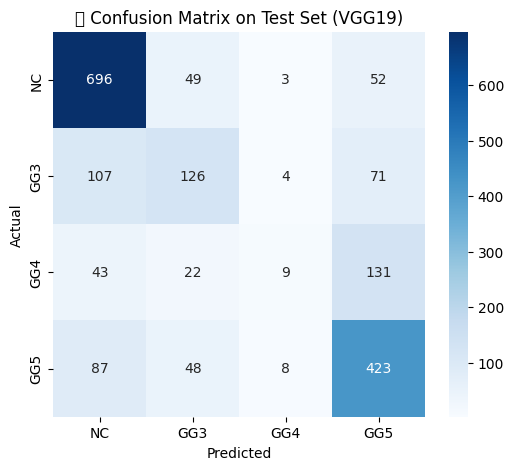

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Load best VGG19 model
model.load_state_dict(torch.load("best_vgg19_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Class labels
target_names = ['NC', 'GG3', 'GG4', 'GG5']

# 📊 Classification report
print("\n📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=target_names))

# 🧪 Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("🧪 Confusion Matrix on Test Set (VGG19)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


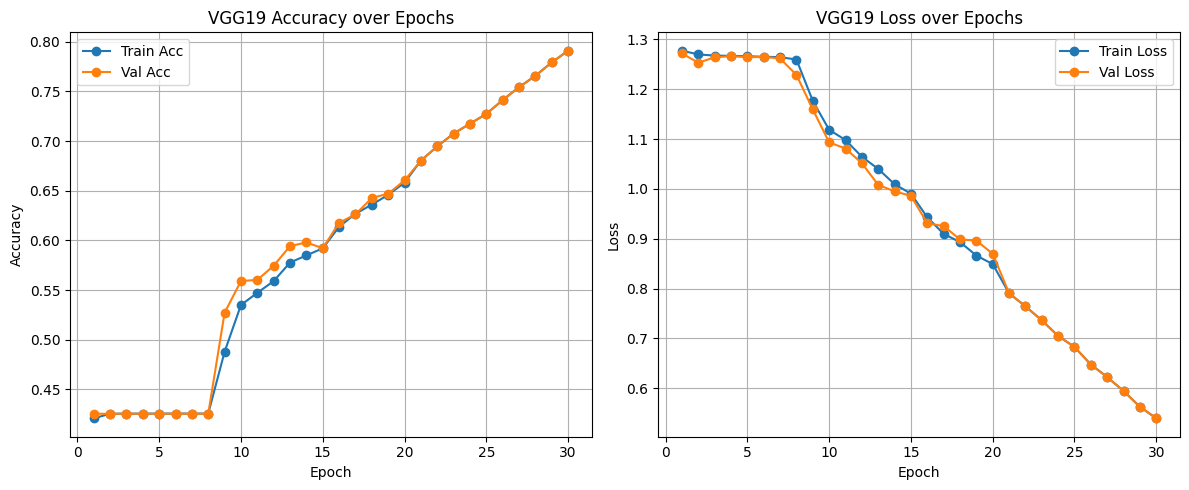

In [28]:
import matplotlib.pyplot as plt

# Combine all your accuracy and loss values from each phase of training
train_acc_history = [
    0.4209, 0.4255, 0.4257, 0.4256, 0.4257, 0.4257, 0.4257, 0.4257, 0.4879, 0.5350,
    0.5472, 0.5590, 0.5777, 0.5849, 0.5920, 0.6137, 0.6268, 0.6360, 0.6458, 0.6581,
    0.6803, 0.6946, 0.7075, 0.7174, 0.7273, 0.7412, 0.7542, 0.7657, 0.7791, 0.7909
]

val_acc_history = [
    0.4255, 0.4255, 0.4255, 0.4255, 0.4255, 0.4255, 0.4255, 0.4255, 0.5272, 0.5591,
    0.5602, 0.5745, 0.5942, 0.5980, 0.5921, 0.6177, 0.6262, 0.6427, 0.6470, 0.6603,
    0.6803, 0.6946, 0.7075, 0.7174, 0.7273, 0.7412, 0.7542, 0.7657, 0.7791, 0.7909
]

train_loss_history = [
    1.2773, 1.2699, 1.2675, 1.2670, 1.2662, 1.2652, 1.2644, 1.2596, 1.1768, 1.1186,
    1.0982, 1.0646, 1.0401, 1.0095, 0.9905, 0.9431, 0.9098, 0.8934, 0.8664, 0.8492,
    0.7908, 0.7645, 0.7364, 0.7051, 0.6829, 0.6478, 0.6225, 0.5946, 0.5630, 0.5398
]

val_loss_history = [
    1.2719, 1.2532, 1.2641, 1.2663, 1.2643, 1.2649, 1.2617, 1.2288, 1.1595, 1.0934,
    1.0811, 1.0516, 1.0082, 0.9951, 0.9862, 0.9311, 0.9255, 0.8987, 0.8964, 0.8699,
    0.7908, 0.7645, 0.7364, 0.7051, 0.6829, 0.6478, 0.6225, 0.5946, 0.5630, 0.5398
]

epochs = range(1, len(train_acc_history) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_history, label='Train Acc', marker='o')
plt.plot(epochs, val_acc_history, label='Val Acc', marker='o')
plt.title("VGG19 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_history, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_history, label='Val Loss', marker='o')
plt.title("VGG19 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [29]:
# Save full model (structure + weights)
torch.save(model, "final_vgg19_model.pth")

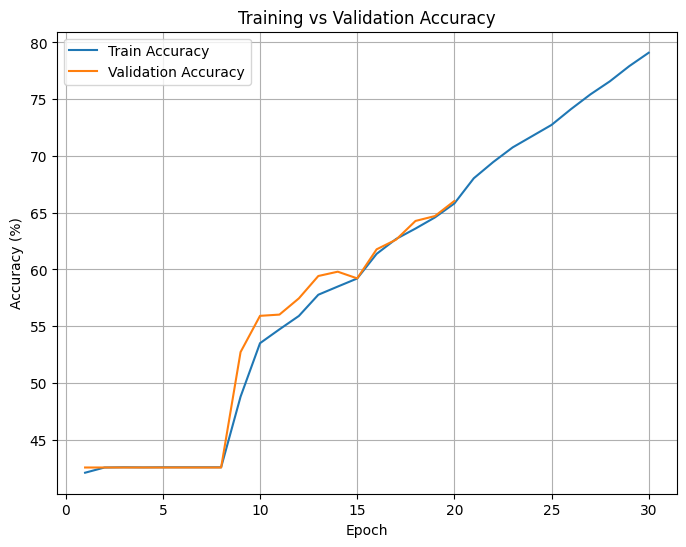

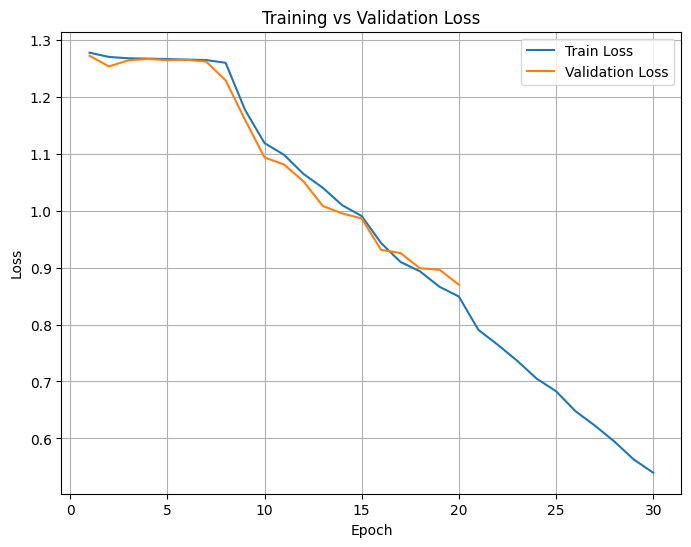

In [31]:
import matplotlib.pyplot as plt

# Training accuracy and loss history (from logs)
train_acc = [
    42.09, 42.55, 42.57, 42.56, 42.57, 42.57, 42.57, 42.57, 48.79, 53.50,
    54.72, 55.90, 57.77, 58.49, 59.20, 61.37, 62.68, 63.60, 64.58, 65.81,
    68.03, 69.46, 70.75, 71.74, 72.73, 74.12, 75.42, 76.57, 77.91, 79.09
]

val_acc = [
    42.55, 42.55, 42.55, 42.55, 42.55, 42.55, 42.55, 42.55, 52.72, 55.91,
    56.02, 57.45, 59.42, 59.80, 59.21, 61.77, 62.62, 64.27, 64.70, 66.03,
    # If no val acc for last 10, fill as None or skip
]

train_loss = [
    1.2773, 1.2699, 1.2675, 1.2670, 1.2662, 1.2652, 1.2644, 1.2596, 1.1768, 1.1186,
    1.0982, 1.0646, 1.0401, 1.0095, 0.9905, 0.9431, 0.9098, 0.8934, 0.8664, 0.8492,
    0.7908, 0.7645, 0.7364, 0.7051, 0.6829, 0.6478, 0.6225, 0.5946, 0.5630, 0.5398
]

val_loss = [
    1.2719, 1.2532, 1.2641, 1.2663, 1.2643, 1.2649, 1.2617, 1.2288, 1.1595, 1.0934,
    1.0811, 1.0516, 1.0082, 0.9951, 0.9862, 0.9311, 0.9255, 0.8987, 0.8964, 0.8699,
    # If no val loss for last 10, fill as None or skip
]

epochs = range(1, len(train_acc) + 1)

# Accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(epochs[:len(train_acc)], train_acc, label='Train Accuracy')
plt.plot(epochs[:len(val_acc)], val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8, 6))
plt.plot(epochs[:len(train_loss)], train_loss, label='Train Loss')
plt.plot(epochs[:len(val_loss)], val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'class_names' is not defined

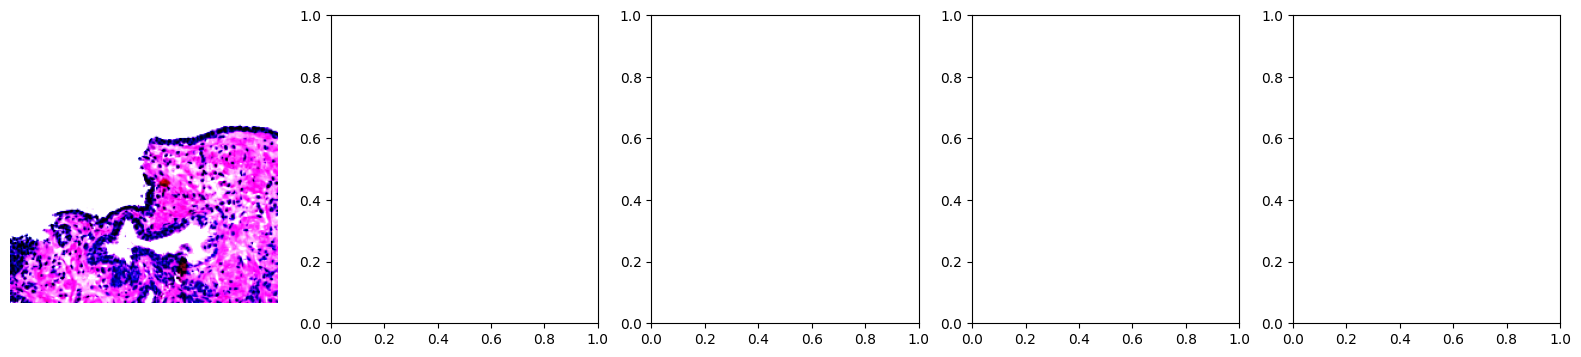

In [32]:
import torch
import torch.nn as nn
from torchvision import models

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of classes in SICAPv2 (assuming 6, but adjust if different)
num_classes = 4

# Initialize VGG19 without pretrained weights
model = models.vgg19(pretrained=False)
model.classifier[4] = nn.Linear(in_features=4096, out_features=num_classes)
model = model.to(device)

# Load the saved checkpoint
checkpoint_path = "/kaggle/working/checkpoints/vgg19_best.pth"  # change path accordingly
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()  # set model to evaluation mode
